<a href="https://colab.research.google.com/github/chrisrichardson/linear-algebra/blob/main/06_GPU_Iterative_Solver_CG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Running Conjugate Gradient on a GPU

You will need to choose a GPU instance (T4) to run this notebook.
Because CG only uses basic operations (dot product, MatVec and axpy) it is ideal to run on a GPU. In fact, we don't need to change the code **at all**. Just change the inputs!

In [1]:
# Import the required libraries
!pip install pyamg
import pyamg
import numpy as np
import matplotlib.pyplot as plt
import cupyx.scipy.sparse
import cupy as cp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.6 MB/s eta 0:00:00


In [11]:
# Set up a linear problem which is SPD
n = 200
A = pyamg.gallery.poisson((n, n))

# Copy the matrix to GPU and create b on GPU
Acu = cupyx.scipy.sparse.csr_matrix(A)
bcu = cp.ones(Acu.shape[1])

In [12]:
# Conjugate gradient solver
# Solves A.x = b
#
def cg_solve(A, b, x):
  r = b - A @ x
  p = r.copy()
  tol = 1e-15
  rnorm2 = r.dot(r)
  while (rnorm2 > tol):
    y = A @ p
    alpha = rnorm2/p.dot(y)
    x += alpha*p
    r -= alpha*y
    rnorm2_new = r.dot(r)
    beta = rnorm2_new/rnorm2
    rnorm2 = rnorm2_new
    p = beta*p + r

## Test the solver

Run the solver, and plot the output.

In [13]:
xcu = cp.zeros_like(bcu)
cg_solve(Acu, bcu, xcu)

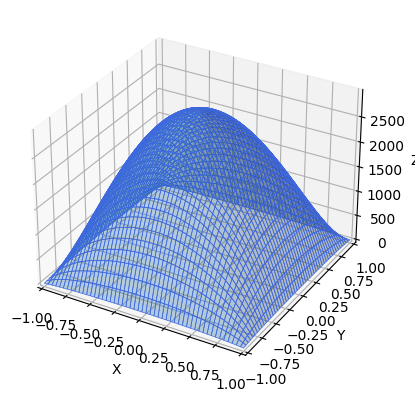

In [14]:
# Copy result back from the GPU
x = xcu.get()

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

ax = plt.figure().add_subplot(projection='3d')
X, Y = np.meshgrid(np.linspace(-1, 1, n),
                   np.linspace(-1, 1, n))

# Plot the 3D surface
ax.plot_surface(X, Y, x.reshape((n,n)), edgecolor='royalblue', lw=0.5, alpha=0.3);

ax.set(xlim=(-1, 1), ylim=(-1, 1), zlim=(0, x.max()),
       xlabel='X', ylabel='Y', zlabel='Z');



Update the code to count the number of iterations. To reach machine precision it should take at most `N` iterations, (for an NxN matrix). For this matrix, it will be much less.